<a href="https://colab.research.google.com/github/Ritwik411/Network_Intrusion_Detection/blob/master/Network_Intrusion_Detection(100-Percent).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Network Intrusion Detection System (NIDS)</h1>
                                  
---
<br>
<h3>Ritwik Gupta 17BCI0074
<br>
Kaustubh Kumar 17BCI0049
<br>
Silvi Taneja 19BCE0782
</h3>

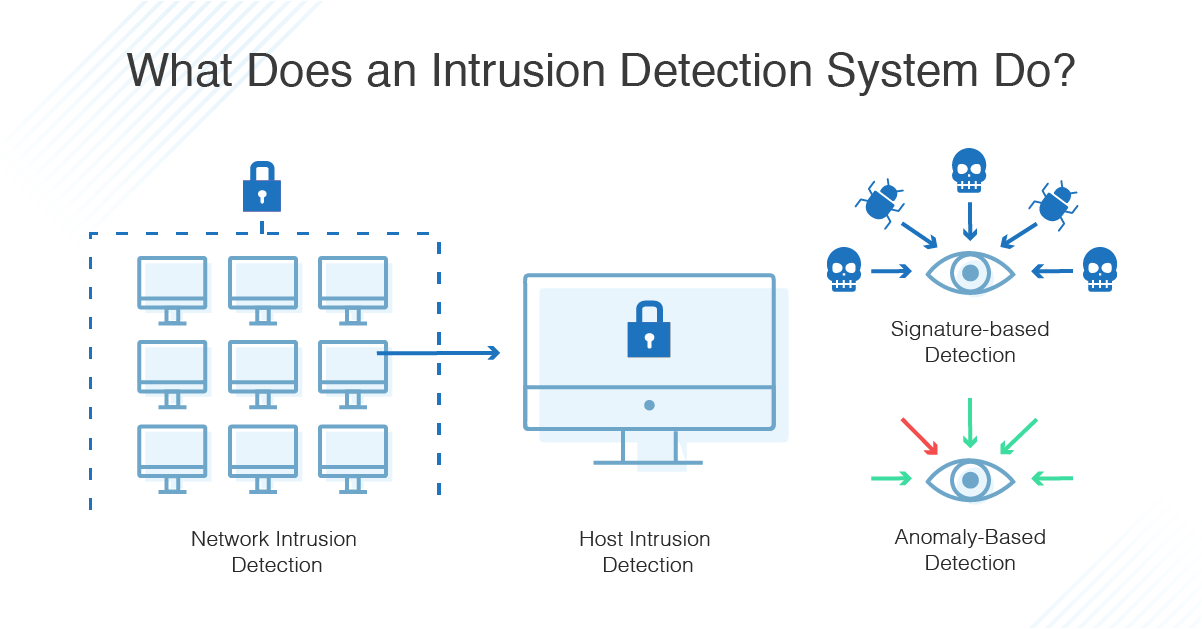

<h3>1.	Signature-based Method:</h3>

Signature-based IDS detects the attacks on the basis of the specific patterns such as number of bytes or number of 1’s or number of 0’s in the network  traffic. It also detects on the basis of the already known malicious instruction sequence that is used by the malware.

<h3>2.	Anomaly-based Method:</h3>

Anomaly-based IDS was introduced to detect the unknown malware attacks as new malware are developed rapidly. In anomaly-based IDS there is use of machine learning to create a trustful activity model and anything coming is compared with that model and it is declared suspicious if it is not found in model.


## Import the libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')
import imblearn
%matplotlib inline

## Load the Dataset
We have used the NSL KDD Dataset which is cleaned and upgraded version of the KDD'99 dataset which was mainly used for Intrusion detection earlier. 
The KDD'99 Dataset - http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

The NSL-KDD Dataset - https://www.unb.ca/cic/datasets/nsl.html

The names and description of the columns were obtained from - https://docs.google.com/spreadsheets/d/1uDYzhEuKlXiM-f2f4f_gthgS0uqh2NN-lzR9dGxP2ZI/edit#gid=0

In [3]:
# 42 columns present in the datset
datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

# Load NSL_KDD train dataset
dfkdd_train = pd.read_table("/content/drive/My Drive/NIDS/KDDTrain.txt", sep=",", names=datacols)
dfkdd_train = dfkdd_train.iloc[:,:-1]

# Load NSL_KDD test dataset
dfkdd_test = pd.read_table("/content/drive/My Drive/NIDS/KDDTest.txt", sep=",", names=datacols)
dfkdd_test = dfkdd_test.iloc[:,:-1]

### Training dataset

In [4]:
dfkdd_train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [5]:
print('Train set dimension: {} rows, {} columns'.format(dfkdd_train.shape[0], dfkdd_train.shape[1]))

Train set dimension: 125973 rows, 42 columns


### Testing Dataset

In [6]:
dfkdd_test.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan


In [7]:
print('Test set dimension: {} rows, {} columns'.format(dfkdd_test.shape[0], dfkdd_test.shape[1]))

Test set dimension: 22544 rows, 42 columns


Thanks to the paper by Yogita B. Bhavsar [Intrusion Detection System Using Data Mining Technique](https://ijetae.com/files/Volume3Issue3/IJETAE_0313_100.pdf), we were able to classify the attack types as - 

1. Denial of Service (DoS)
2. Probing Attack (Probe)
3. User to Root Attack (U2R)
4. Remote to Local Attack (R2L)



In [8]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

Creating the column attack class to categorize the attack class into 4 labels.

In [9]:
dfkdd_train['attack_class'] = dfkdd_train['attack'].apply(lambda x: mapping[x])
dfkdd_test['attack_class'] = dfkdd_test['attack'].apply(lambda x: mapping[x])

Drop the original attack column as it is no longer needed.

In [10]:
dfkdd_train.drop(['attack'], axis=1, inplace=True)
dfkdd_test.drop(['attack'], axis=1, inplace=True)

In [11]:
dfkdd_train['attack_class'].value_counts()

Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: attack_class, dtype: int64

## Exploring the Data

In [12]:
dfkdd_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Dropping the "num_outbound_cmds" column as there are only 0's present in it.

In [13]:
dfkdd_train.drop(['num_outbound_cmds'], axis=1, inplace=True)
dfkdd_test.drop(['num_outbound_cmds'], axis=1, inplace=True)

Adding additional columns of frequency of attacks which will act as an additional parameter to identify the type of attack.

In [14]:
attack_class_freq_train = dfkdd_train[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_test = dfkdd_test[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_test
attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_freq_test['frequency_percent_test'] = round((100 * attack_class_freq_test / attack_class_freq_test.sum()),2)
attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1) 
attack_class_dist

,attack_class,frequency_percent_train,attack_class,frequency_percent_test
Normal,67343,53.46,9711,43.08
DoS,45927,36.46,7458,33.08
Probe,11656,9.25,2421,10.74
R2L,995,0.79,2754,12.22
U2R,52,0.04,200,0.89


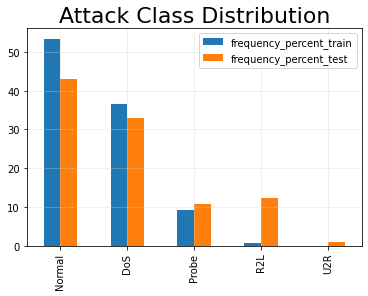

<Figure size 1440x1440 with 0 Axes>

In [15]:
plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar")
plt.figure(figsize=(20,20));
plot.set_title("Attack Class Distribution", fontsize=22)
plot.grid(color='lightgray', alpha=0.4)
plot.legend()

## Feature Scaling

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = dfkdd_train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(dfkdd_train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(dfkdd_test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

## Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = dfkdd_train.select_dtypes(include=['object']).copy()
cattest = dfkdd_test.select_dtypes(include=['object']).copy()

traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['attack_class'], axis=1)
enctest = testcat.drop(['attack_class'], axis=1)

cat_Ytrain = traincat[['attack_class']].copy()
cat_Ytest = testcat[['attack_class']].copy()

## Sampling

In [18]:
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

# define columns and extract encoded train set for sampling 
sc_traindf = dfkdd_train.select_dtypes(include=['float64','int64'])
refclasscol = pd.concat([sc_traindf, enctrain], axis=1).columns
refclass = np.concatenate((sc_train, enctrain.values), axis=1)
X = refclass

# reshape target column to 1D array shape  
c, r = cat_Ytest.values.shape
y_test = cat_Ytest.values.reshape(c,)

c, r = cat_Ytrain.values.shape
y = cat_Ytrain.values.reshape(c,)

# apply the random over-sampling
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_sample(X, y)
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 67343, 0: 45927, 2: 11656, 3: 995, 4: 52})
Resampled dataset shape Counter({1: 67343, 0: 67343, 3: 67343, 2: 67343, 4: 67343})


## Feature Selection

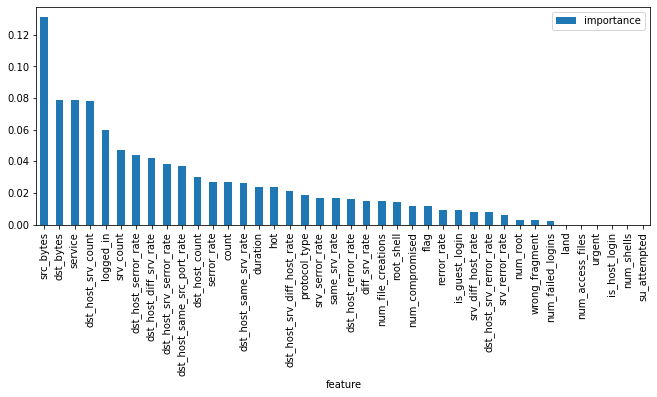

In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(X_res, y_res);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':refclasscol,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [20]:
from sklearn.feature_selection import RFE
import itertools
# rfc = RandomForestClassifier()

# create the RFE model and selected 13 attributes
rfe = RFE(rfc, n_features_to_select=13)
rfe = rfe.fit(X_res, y_res)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), refclasscol)]
selected_features = [v for i, v in feature_map if i==True]

In [21]:
print(selected_features)

['duration', 'src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count', 'srv_serror_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'service']


In [22]:
# define columns to new dataframe
newcol = list(refclasscol)
newcol.append('attack_class')

# add a dimension to target
new_y_res = y_res[:, np.newaxis]

# create a dataframe from sampled data
res_arr = np.concatenate((X_res, new_y_res), axis=1)
res_df = pd.DataFrame(res_arr, columns = newcol) 

# create test dataframe
reftest = pd.concat([sc_testdf, testcat], axis=1)
reftest['attack_class'] = reftest['attack_class'].astype(np.float64)
reftest['protocol_type'] = reftest['protocol_type'].astype(np.float64)
reftest['flag'] = reftest['flag'].astype(np.float64)
reftest['service'] = reftest['service'].astype(np.float64)

res_df.shape
reftest.shape

(22544, 41)

In [23]:
from collections import defaultdict
classdict = defaultdict(list)

# create two-target classes (normal class and an attack class)  
attacklist = [('DoS', 0.0), ('Probe', 2.0), ('R2L', 3.0), ('U2R', 4.0)]
normalclass = [('Normal', 1.0)]

def create_classdict():
    for j, k in normalclass: 
        for i, v in attacklist: 
            restrain_set = res_df.loc[(res_df['attack_class'] == k) | (res_df['attack_class'] == v)]
            classdict[j +'_' + i].append(restrain_set)
            # test labels
            reftest_set = reftest.loc[(reftest['attack_class'] == k) | (reftest['attack_class'] == v)]
            classdict[j +'_' + i].append(reftest_set)
        
create_classdict()

In [24]:
pretrain = classdict['Normal_DoS'][0]
pretest = classdict['Normal_DoS'][1]
grpclass = 'Normal_DoS'

## Pre-processing

In [25]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

Xresdf = pretrain 
newtest = pretest

Xresdfnew = Xresdf[selected_features]
Xresdfnum = Xresdfnew.drop(['service'], axis=1)
Xresdfcat = Xresdfnew[['service']].copy()

Xtest_features = newtest[selected_features]
Xtestdfnum = Xtest_features.drop(['service'], axis=1)
Xtestcat = Xtest_features[['service']].copy()

In [26]:
# Fit train data
enc.fit(Xresdfcat)

# Transform train data
X_train_1hotenc = enc.transform(Xresdfcat).toarray()
X_test_1hotenc = enc.fit_transform(Xtestcat).toarray()

In [27]:
# Transform test data
X_train = np.concatenate((Xresdfnum.values, X_train_1hotenc), axis=1)
X_test = np.concatenate((Xtestdfnum.values, X_test_1hotenc), axis=1)

In [34]:
y_train = Xresdf[['attack_class']].copy()
c, r = y_train.values.shape
Y_train = y_train.values.reshape(c,)
y_test = newtest[['attack_class']].copy()
c, r = y_test.values.shape
Y_test = y_test.values.reshape(c,)

# Training

In [35]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

### 1. KNeighborsClassifier

In [36]:
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train); 

### 2. LogisticRegression

In [37]:
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

### 3.Naive Bayes

In [38]:
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

### 4. Decision Tree

In [39]:
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train);

### 5. Random Forest

In [40]:
RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
RF_Classifier.fit(X_train, Y_train);  

### 6. SVM

In [41]:
SVC_Classifier = SVC(random_state=0)
SVC_Classifier.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

### 7. Ensemble Model

In [42]:
combined_model = [('Naive Baye Classifier', BNB_Classifier), 
                 ('Decision Tree Classifier', DTC_Classifier), 
                 ('KNeighborsClassifier', KNN_Classifier), 
                 ('LogisticRegression', LGR_Classifier)
                ]
VotingClassifier =  VotingClassifier(estimators = combined_model,voting = 'soft', n_jobs=-1)
VotingClassifier.fit(X_train, Y_train);

# Evaluation

In [46]:
from sklearn import metrics

models = []
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))
models.append(('RandomForest Classifier', RF_Classifier))
models.append(('SVM Classifier', SVC_Classifier))
models.append(('VotingClassifier', VotingClassifier))

for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} Model Evaluation =============================='.format(i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9770354773899952

Model Accuracy:
 0.9770428997817145

Confusion matrix:
 [[65020  2323]
 [  769 66574]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     67343
         1.0       0.97      0.99      0.98     67343

    accuracy                           0.98    134686
   macro avg       0.98      0.98      0.98    134686
weighted avg       0.98      0.98      0.98    134686



============================== Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9997624140953267

Model Accuracy:
 0.9999480272634127

Confusion matrix:
 [[67343     0]
 [    7 67336]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     67343
         1.0       1.00      1